# In this notebook a sensitivity analysis will be performed. The best Automatic Trader will be tested with unseen symbols, without retraining, in the Test period.

In [1]:
# Basic imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import scipy.optimize as spo
import sys
from time import time
from sklearn.metrics import r2_score, median_absolute_error
from multiprocessing import Pool
import pickle

%matplotlib inline

%pylab inline
pylab.rcParams['figure.figsize'] = (20.0, 10.0)

%load_ext autoreload
%autoreload 2

sys.path.append('../../')

import recommender.simulator as sim
from utils.analysis import value_eval
from recommender.agent import Agent
from functools import partial

Populating the interactive namespace from numpy and matplotlib


In [2]:
def show_results(results_list, data_in_df, symbol, graph=False):
    for values in results_list:
        total_value = values.sum(axis=1)
        print('Sharpe ratio: {}\nCum. Ret.: {}\nAVG_DRET: {}\nSTD_DRET: {}\nFinal value: {}'.format(*value_eval(pd.DataFrame(total_value))))
        print('-'*100)
        initial_date = total_value.index[0]
        compare_results = data_in_df.loc[initial_date:, 'Close'].copy()
        compare_results.name = symbol
        compare_results_df = pd.DataFrame(compare_results)
        compare_results_df['portfolio'] = total_value
        std_comp_df = compare_results_df / compare_results_df.iloc[0]
        if graph:
            plt.figure()
            std_comp_df.plot()

## Let's get some "good" symbols (low missing data)

In [3]:
raw_data_df = pd.read_pickle('../../data/data_df.pkl')

In [4]:
close_df = raw_data_df.unstack().loc[:,(slice(None), 'Close')]
close_df.columns = close_df.columns.droplevel('feature')
missing_df = close_df.isnull().sum() / close_df.shape[0]
good_close = list(close_df.loc[:,missing_df < 0.001].columns)
len(good_close)

279

In [5]:
volume_df = raw_data_df.unstack().loc[:,(slice(None), 'Volume')]
volume_df.columns = volume_df.columns.droplevel('feature')
missing_df = volume_df.isnull().sum() / volume_df.shape[0]
good_volume = list(volume_df.loc[:,missing_df < 0.001].columns)
len(good_volume)

279

In [6]:
good_symbols = list(set(good_close).intersection(good_volume))
good_symbols

['AFL',
 'CHK',
 'HD',
 'APC',
 'GWW',
 'ADP',
 'GIS',
 'TSN',
 'LEN',
 'TMO',
 'FOXA',
 'RRC',
 'SLB',
 'F',
 'ROK',
 'XLNX',
 'MAS',
 'SYK',
 'SYMC',
 'IPG',
 'BDX',
 'SRE',
 'RJF',
 'PPL',
 'JEC',
 'HSY',
 'PX',
 'NEM',
 'BK',
 'ROST',
 'TWX',
 'HOG',
 'LLY',
 'L',
 'TROW',
 'TRV',
 'COP',
 'AME',
 'ESRX',
 'STI',
 'TIF',
 'SPY',
 'XEL',
 'TGNA',
 'BAC',
 'MOS',
 'ES',
 'FAST',
 'REGN',
 'SCG',
 'FMC',
 'WY',
 'M',
 'EA',
 'EFX',
 'AEP',
 'DOW',
 'ETR',
 'HCN',
 'PBCT',
 'BEN',
 'KO',
 'BBY',
 'AIG',
 'HON',
 'PGR',
 'MKC',
 'JNJ',
 'MSI',
 'SPGI',
 'ARNC',
 'USB',
 'BIIB',
 'CELG',
 'MRK',
 'BBBY',
 'CNP',
 'CPB',
 'HRS',
 'WEC',
 'R',
 'BHI',
 'GLW',
 'OKE',
 'IDXX',
 'OXY',
 'HAS',
 'SIG',
 'EXPD',
 'KIM',
 'SPLS',
 'LUV',
 'CTL',
 'CL',
 'DHR',
 'LRCX',
 'ALK',
 'HP',
 'PNW',
 'PSA',
 'PHM',
 'UNH',
 'DOV',
 'NKE',
 'CCL',
 'UHS',
 'TJX',
 'FISV',
 'PCAR',
 'TGT',
 'BF.B',
 'SWK',
 'CAT',
 'KR',
 'ZION',
 'AAPL',
 'AZO',
 'DUK',
 'PAYX',
 'NSC',
 'SNPS',
 'PNC',
 'APH',
 'CSX',


In [7]:
'SPY' in good_symbols

True

In [8]:
good_symbols.remove('SPY')
'SPY' in good_symbols

False

## Let's try to test on one unseen symbol alone

In [9]:
SYMBOL = 'MCD'
AGENT_PICKLE = '../../data/simple_q_learner_1000_states_full_training.pkl'
AGENT_PICKLE = '../../data/simple_q_learner_1000_states_full_training_25_epochs.pkl'

LOOKBACK = -1  # 252*4 + 28
STARTING_DAYS_AHEAD = 252
POSSIBLE_FRACTIONS = [0.0, 1.0]

# Get the data
total_data_train_df = pd.read_pickle('../../data/data_train_val_df.pkl').stack(level='feature')
data_train_df = total_data_train_df[SYMBOL].unstack()
total_data_test_df = pd.read_pickle('../../data/data_test_df.pkl').stack(level='feature')
data_test_df = total_data_test_df[SYMBOL].unstack()
if LOOKBACK == -1:
    total_data_in_df = total_data_train_df
    data_in_df = data_train_df
else:
    data_in_df = data_train_df.iloc[-LOOKBACK:]
    total_data_in_df = total_data_train_df.loc[data_in_df.index[0]:]

env, num_states, num_actions = sim.initialize_env(total_data_in_df, 
                                                  SYMBOL, 
                                                  starting_days_ahead=STARTING_DAYS_AHEAD,
                                                  possible_fractions=POSSIBLE_FRACTIONS,
                                                  n_levels=10)

with open(AGENT_PICKLE, 'rb') as f:
    agent = pickle.load(f)

### Test without retraining. It will probably not work very well, as the thresholds may not be general enough to be transferable between different symbols.

In [10]:
total_data_test_df.unstack().shape

(504, 2495)

Starting simulation for agent: Agent_0. 484 days of simulation to go.
Date 2016-12-28 00:00:00 (simulating until 2016-12-30 00:00:00).  Time: 0.17609357833862305s.  Value: 10115.979999999996.Elapsed time: 8.87047028541565 seconds.
Random Actions Rate: 1.8722659434110675e-06
Sharpe ratio: 0.06382145737380468
Cum. Ret.: 0.003725999999999452
AVG_DRET: 1.9844066420790565e-05
STD_DRET: 0.004935875823908302
Final value: 10037.259999999995
----------------------------------------------------------------------------------------------------


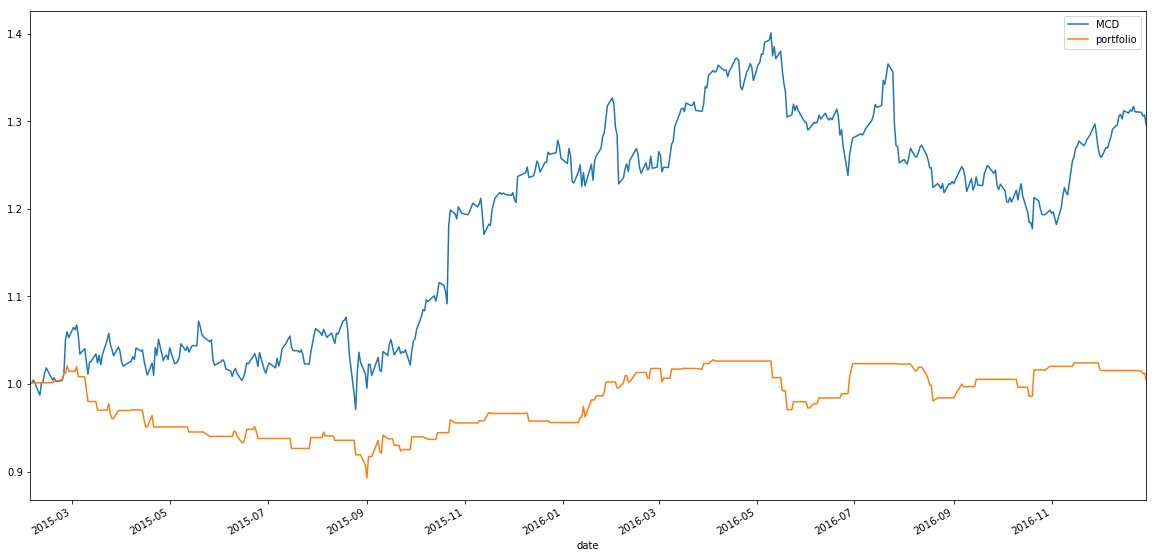

In [11]:
TEST_DAYS_AHEAD = 20

env.set_test_data(total_data_test_df, TEST_DAYS_AHEAD)
tic = time()
results_list = sim.simulate_period(total_data_test_df, 
                                    SYMBOL,
                                    agent,
                                    learn=False,
                                    starting_days_ahead=TEST_DAYS_AHEAD,
                                    possible_fractions=POSSIBLE_FRACTIONS,
                                    verbose=False,
                                    other_env=env)
toc = time()
print('Elapsed time: {} seconds.'.format((toc-tic)))
print('Random Actions Rate: {}'.format(agent.random_actions_rate))
show_results([results_list], data_test_df, SYMBOL, graph=True)

In [12]:
total_value = results_list.sum(axis=1)
sharpe, cumret, _, _, _ = value_eval(pd.DataFrame(total_value))
sharpe_bench, cumret_bench, _, _, _ = value_eval(pd.DataFrame(data_test_df['Close'].iloc[TEST_DAYS_AHEAD:]))

sharpe_q = sharpe / sharpe_bench
cumret_q = cumret / cumret_bench
print('Sharpe Quotient: %f' % sharpe_q)
print('Cumulative Return Quotient: %f' % cumret_q)

Sharpe Quotient: 0.069251
Cumulative Return Quotient: 0.011800


In [13]:
results_df = pd.DataFrame(columns=['sharpe', 'sharpe_bench', 'cum_ret', 'cum_ret_bench', 'sharpe_quotient', 'cum_ret_quotient'])

In [14]:
symbol = SYMBOL
results_df = results_df.append(pd.DataFrame({symbol: {'sharpe': sharpe,
                                         'sharpe_bench': sharpe_bench,
                                         'cum_ret': cumret,
                                         'cum_ret_bench': cumret_bench,
                                         'sharpe_quotient': sharpe_q,
                                         'cum_ret_quotient': cumret_q}}).T)
results_df

,cum_ret,cum_ret_bench,cum_ret_quotient,sharpe,sharpe_bench,sharpe_quotient
MCD,0.003726,0.31575,0.0118,0.063821,0.921594,0.069251


## Let's test it with n_syms random symbols

In [15]:
n_syms = 100

np.random.seed(2017)
random_symbols = np.random.choice(good_symbols, size=n_syms, replace=False)
print('Testing with these symbols:\n{}'.format(random_symbols))

# Set the Agent (It shouldn't change if tested with 'no learning')
AGENT_PICKLE = '../../data/simple_q_learner_1000_states_full_training.pkl'
AGENT_PICKLE = '../../data/simple_q_learner_1000_states_full_training_25_epochs.pkl'

with open(AGENT_PICKLE, 'rb') as f:
    agent = pickle.load(f)

# Results holder
results_df = pd.DataFrame(columns=['sharpe', 
                                   'sharpe_bench', 
                                   'cum_ret', 
                                   'cum_ret_bench', 
                                   'sharpe_quotient', 
                                   'cum_ret_quotient',])

for symbol in random_symbols:
    # Set the environment
    data_test_df = total_data_test_df[symbol].unstack()
    env, num_states, num_actions = sim.initialize_env(total_data_train_df, 
                                                  symbol, 
                                                  starting_days_ahead=STARTING_DAYS_AHEAD,
                                                  possible_fractions=POSSIBLE_FRACTIONS,
                                                  n_levels=10)
    # Test
    TEST_DAYS_AHEAD = 20
    env.set_test_data(total_data_test_df, TEST_DAYS_AHEAD)
    tic = time()
    results_list = sim.simulate_period(total_data_test_df, 
                                    symbol,
                                    agent,
                                    learn=False,
                                    starting_days_ahead=TEST_DAYS_AHEAD,
                                    possible_fractions=POSSIBLE_FRACTIONS,
                                    verbose=False,
                                    other_env=env)
    toc = time()
    
    # Show results
    print('Elapsed time: {} seconds.'.format((toc-tic)))
    print('Random Actions Rate: {}'.format(agent.random_actions_rate))
    show_results([results_list], data_test_df, symbol, graph=False)
    
    # Save some results
    total_value = results_list.sum(axis=1)
    sharpe, cumret, _, _, _ = value_eval(pd.DataFrame(total_value))
    sharpe_bench, cumret_bench, _, _, _ = value_eval(pd.DataFrame(data_test_df['Close'].iloc[TEST_DAYS_AHEAD:]))
    sharpe_q = sharpe / sharpe_bench
    cumret_q = cumret / cumret_bench
    results_df = results_df.append(pd.DataFrame({symbol: {'sharpe': sharpe,
                                         'sharpe_bench': sharpe_bench,
                                         'cum_ret': cumret,
                                         'cum_ret_bench': cumret_bench,
                                         'sharpe_quotient': sharpe_q,
                                         'cum_ret_quotient': cumret_q}}).T)

Testing with these symbols:
['CTL' 'PNC' 'PG' 'BAC' 'OMC' 'DOW' 'CERN' 'LB' 'STT' 'MHK' 'EIX' 'HAL'
 'AMD' 'CMS' 'KR' 'ROP' 'UTX' 'ADP' 'AZO' 'RRC' 'MRK' 'AIG' 'TWX' 'BBY'
 'HCN' 'ZION' 'DIS' 'AN' 'IPG' 'APH' 'NI' 'STZ' 'SCG' 'NKE' 'WHR' 'PPL'
 'ROK' 'RF' 'HRB' 'HRS' 'DVN' 'WMB' 'TGNA' 'TSO' 'WY' 'IDXX' 'GLW' 'SHW'
 'BIIB' 'AJG' 'UNM' 'CAT' 'EOG' 'PBCT' 'HOG' 'LLY' 'ADSK' 'IBM' 'IR' 'GD'
 'BAX' 'CL' 'ADM' 'AMGN' 'PSA' 'APC' 'ESRX' 'EXC' 'ADBE' 'GWW' 'CAG' 'NUE'
 'CHK' 'XRAY' 'HSY' 'DTE' 'CLX' 'LRCX' 'LNT' 'MCD' 'M' 'BBBY' 'XEL' 'KSS'
 'WFM' 'PX' 'CELG' 'MOS' 'DHI' 'PPG' 'PHM' 'BA' 'AVY' 'FAST' 'SYMC' 'MTB'
 'PKI' 'DOV' 'WMT' 'PVH']
Starting simulation for agent: Agent_0. 484 days of simulation to go.
Date 2016-12-28 00:00:00 (simulating until 2016-12-30 00:00:00).  Time: 0.23154973983764648s.  Value: 9529.020000000013.Elapsed time: 10.270526885986328 seconds.
Random Actions Rate: 1.8722659434110675e-06
Sharpe ratio: -0.045193201707058844
Cum. Ret.: -0.04709799999999864
AVG_DRET: -3.324

In [16]:
results_df

,cum_ret,cum_ret_bench,cum_ret_quotient,sharpe,sharpe_bench,sharpe_quotient
CTL,-0.047098,-0.377813,0.124660,-0.045193,-0.669725,0.067480
PNC,0.146167,0.357159,0.409249,0.742780,0.849174,0.874709
PG,0.038231,-0.012218,-3.129060,0.263985,0.033548,7.868767
BAC,0.173784,0.429495,0.404624,0.617671,0.793640,0.778276
OMC,0.106878,0.163500,0.653689,0.614947,0.528033,1.164598
DOW,0.317834,0.265369,1.197704,1.157241,0.611136,1.893589
CERN,-0.197363,-0.290124,0.680270,-0.961937,-0.589201,1.632613
LB,0.139757,-0.224042,-0.623797,0.630058,-0.363500,-1.733308
STT,-0.107088,0.064949,-1.648794,-0.516147,0.257145,-2.007217
MHK,0.221502,0.197769,1.120006,1.003797,0.505824,1.984481


In [17]:
results_df['sharpe_delta'] = results_df['sharpe'] - results_df['sharpe_bench']
results_df

,cum_ret,cum_ret_bench,cum_ret_quotient,sharpe,sharpe_bench,sharpe_quotient,sharpe_delta
CTL,-0.047098,-0.377813,0.124660,-0.045193,-0.669725,0.067480,0.624532
PNC,0.146167,0.357159,0.409249,0.742780,0.849174,0.874709,-0.106394
PG,0.038231,-0.012218,-3.129060,0.263985,0.033548,7.868767,0.230436
BAC,0.173784,0.429495,0.404624,0.617671,0.793640,0.778276,-0.175969
OMC,0.106878,0.163500,0.653689,0.614947,0.528033,1.164598,0.086913
DOW,0.317834,0.265369,1.197704,1.157241,0.611136,1.893589,0.546105
CERN,-0.197363,-0.290124,0.680270,-0.961937,-0.589201,1.632613,-0.372736
LB,0.139757,-0.224042,-0.623797,0.630058,-0.363500,-1.733308,0.993558
STT,-0.107088,0.064949,-1.648794,-0.516147,0.257145,-2.007217,-0.773292
MHK,0.221502,0.197769,1.120006,1.003797,0.505824,1.984481,0.497974


In [18]:
delta = results_df['sharpe_delta']
pd.DataFrame(delta.describe())

,sharpe_delta
count,100.000000
mean,-0.118791
std,0.759289
min,-1.797214
25%,-0.666129
50%,-0.074547
75%,0.400861
max,1.688194


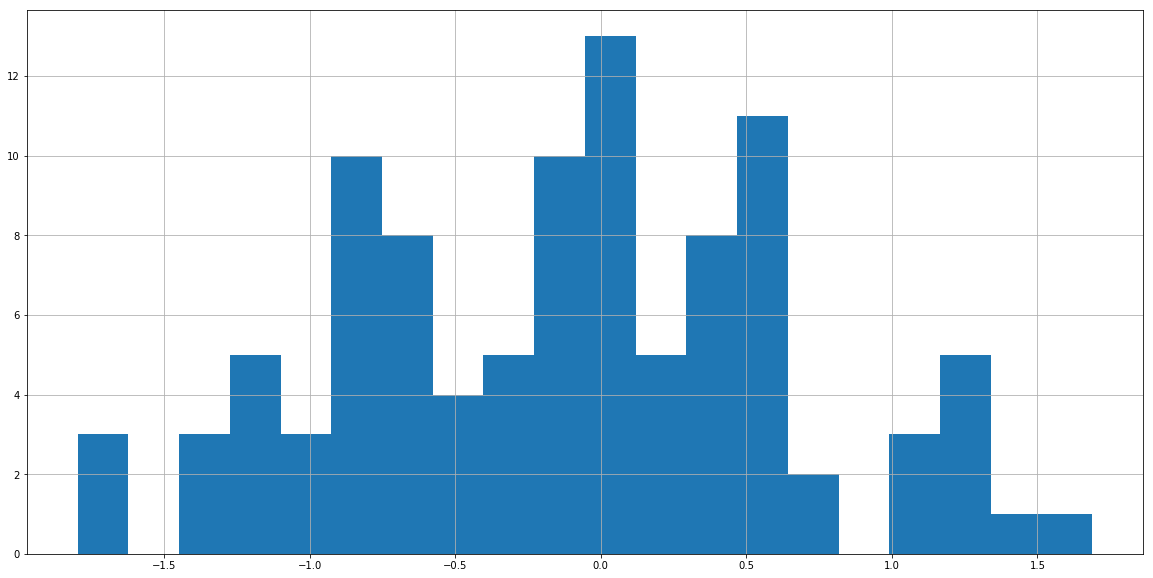

In [19]:
delta.hist(bins=20)